# Healthcare Chatbot - Medical QA System

This notebook implements a domain-specific chatbot for healthcare using a fine-tuned Transformer model.

**Project Overview:**
- **Domain:** Healthcare
- **Dataset:** MedQuAD (Medical Question-Answer Dataset)
- **Approach:** Generative QA
- **Model:** Flan-T5 (Google's instruction-tuned T5)
- **Framework:** TensorFlow + Hugging Face Transformers

**Dataset Columns:**
- `question`: Medical question
- `answer`: Expert medical answer  
- `source`: Source of the QA pair
- `focus_area`: Medical topic/area


## 1. Setup and Installation


In [1]:
# Install required packages
# IMPORTANT: Install tf-keras first for Keras 3 compatibility!
%pip install -q tf-keras
%pip install -q transformers tensorflow pandas numpy scikit-learn nltk datasets evaluate rouge-score sacrebleu matplotlib seaborn kagglehub

print("✓ All packages installed successfully!")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.4 MB/s eta 0:00:00
✓ All packages installed successfully!


In [2]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path
from collections import Counter

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize

# Hugging Face
from transformers import (
    AutoTokenizer,
    TFAutoModelForSeq2SeqLM,
    create_optimizer
)
from datasets import Dataset
import evaluate

# TensorFlow
import tensorflow as tf

# Sklearn
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow version: 2.19.0
GPU Available: True


In [3]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK data downloaded")

NLTK data downloaded


## 2. Data Loading and Exploration


In [4]:
# Download dataset using Kaggle Hub API
import kagglehub
import shutil

print("Downloading MedQuAD dataset from Kaggle...")
print("This may take a few minutes on first run...")

# Download latest version
dataset_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

print(f"\n✓ Dataset downloaded to: {dataset_path}")

# Copy to data directory
import os
from pathlib import Path

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Find the CSV file in the downloaded path
csv_files = list(Path(dataset_path).glob('*.csv'))
if csv_files:
    source_file = csv_files[0]
    dest_file = data_dir / 'medquad.csv'
    shutil.copy(source_file, dest_file)
    print(f"✓ Dataset copied to: {dest_file}")
else:
    print("⚠️ No CSV file found. Please check the dataset structure.")
    print(f"Files in dataset: {list(Path(dataset_path).glob('*'))}")


This may take a few minutes on first run...


100%|██████████| 4.95M/4.95M [00:01<00:00, 3.87MB/s]

Extracting files...



✓ Dataset downloaded to: /root/.cache/kagglehub/datasets/pythonafroz/medquad-medical-question-answer-for-ai-research/versions/1
✓ Dataset copied to: data/medquad.csv


In [5]:
# Load the MedQuAD dataset
data_path = 'data/medquad.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nDataset Info:")
df.info()
print(f"\nFirst few rows:")
df.head()


Dataset shape: (16412, 4)

Column names: ['question', 'answer', 'source', 'focus_area']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB

First few rows:


,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [6]:
# Display sample Q&A pairs
print("Sample Medical Q&A Pairs:\n")
print("="*100)
for idx in range(min(3, len(df))):
    print(f"\nExample {idx+1}:")
    print(f"Question: {df.iloc[idx]['question']}")
    print(f"Answer: {df.iloc[idx]['answer'][:300]}...")
    if 'source' in df.columns:
        print(f"Source: {df.iloc[idx]['source']}")
    if 'focus_area' in df.columns:
        print(f"Focus Area: {df.iloc[idx]['focus_area']}")
    print("-"*100)


Sample Medical Q&A Pairs:


Example 1:
Question: What is (are) Glaucoma ?
Answer: Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage syste...
Source: NIHSeniorHealth
Focus Area: Glaucoma
----------------------------------------------------------------------------------------------------

Example 2:
Question: What causes Glaucoma ?
Answer: Nearly 2.7 million people have glaucoma, a leading cause of blindness in the United States. Although anyone can get glaucoma, some people are at higher risk. They include - African-Americans over age 40  - everyone over age 60, especially Hispanics/Latinos  - people with a family history of glaucoma...
Source: NIHSeniorHealth
Focus Area: Glaucoma
------------------------------------------------------------------

In [7]:
# Basic statistics
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)

# Text length analysis
df['question_length'] = df['question'].astype(str).apply(len)
df['answer_length'] = df['answer'].astype(str).apply(len)
df['question_words'] = df['question'].astype(str).apply(lambda x: len(x.split()))
df['answer_words'] = df['answer'].astype(str).apply(lambda x: len(x.split()))

print("\nText Length Statistics:")
print(df[['question_length', 'answer_length', 'question_words', 'answer_words']].describe())


Missing Values:
question       0
answer         5
source         0
focus_area    14
dtype: int64


Text Length Statistics:
       question_length  answer_length  question_words  answer_words
count     16412.000000   16412.000000    16412.000000  16412.000000
mean         50.684438    1303.056483        8.211918    201.293322
std          16.925355    1656.597408        2.381260    248.466938
min          16.000000       3.000000        3.000000      1.000000
25%          38.000000     487.000000        6.000000     71.000000
50%          48.000000     889.500000        8.000000    138.000000
75%          61.000000    1589.000000       10.000000    252.000000
max         191.000000   29046.000000       27.000000   4281.000000


## 3. Data Visualization

Let's create comprehensive visualizations to understand the dataset better.


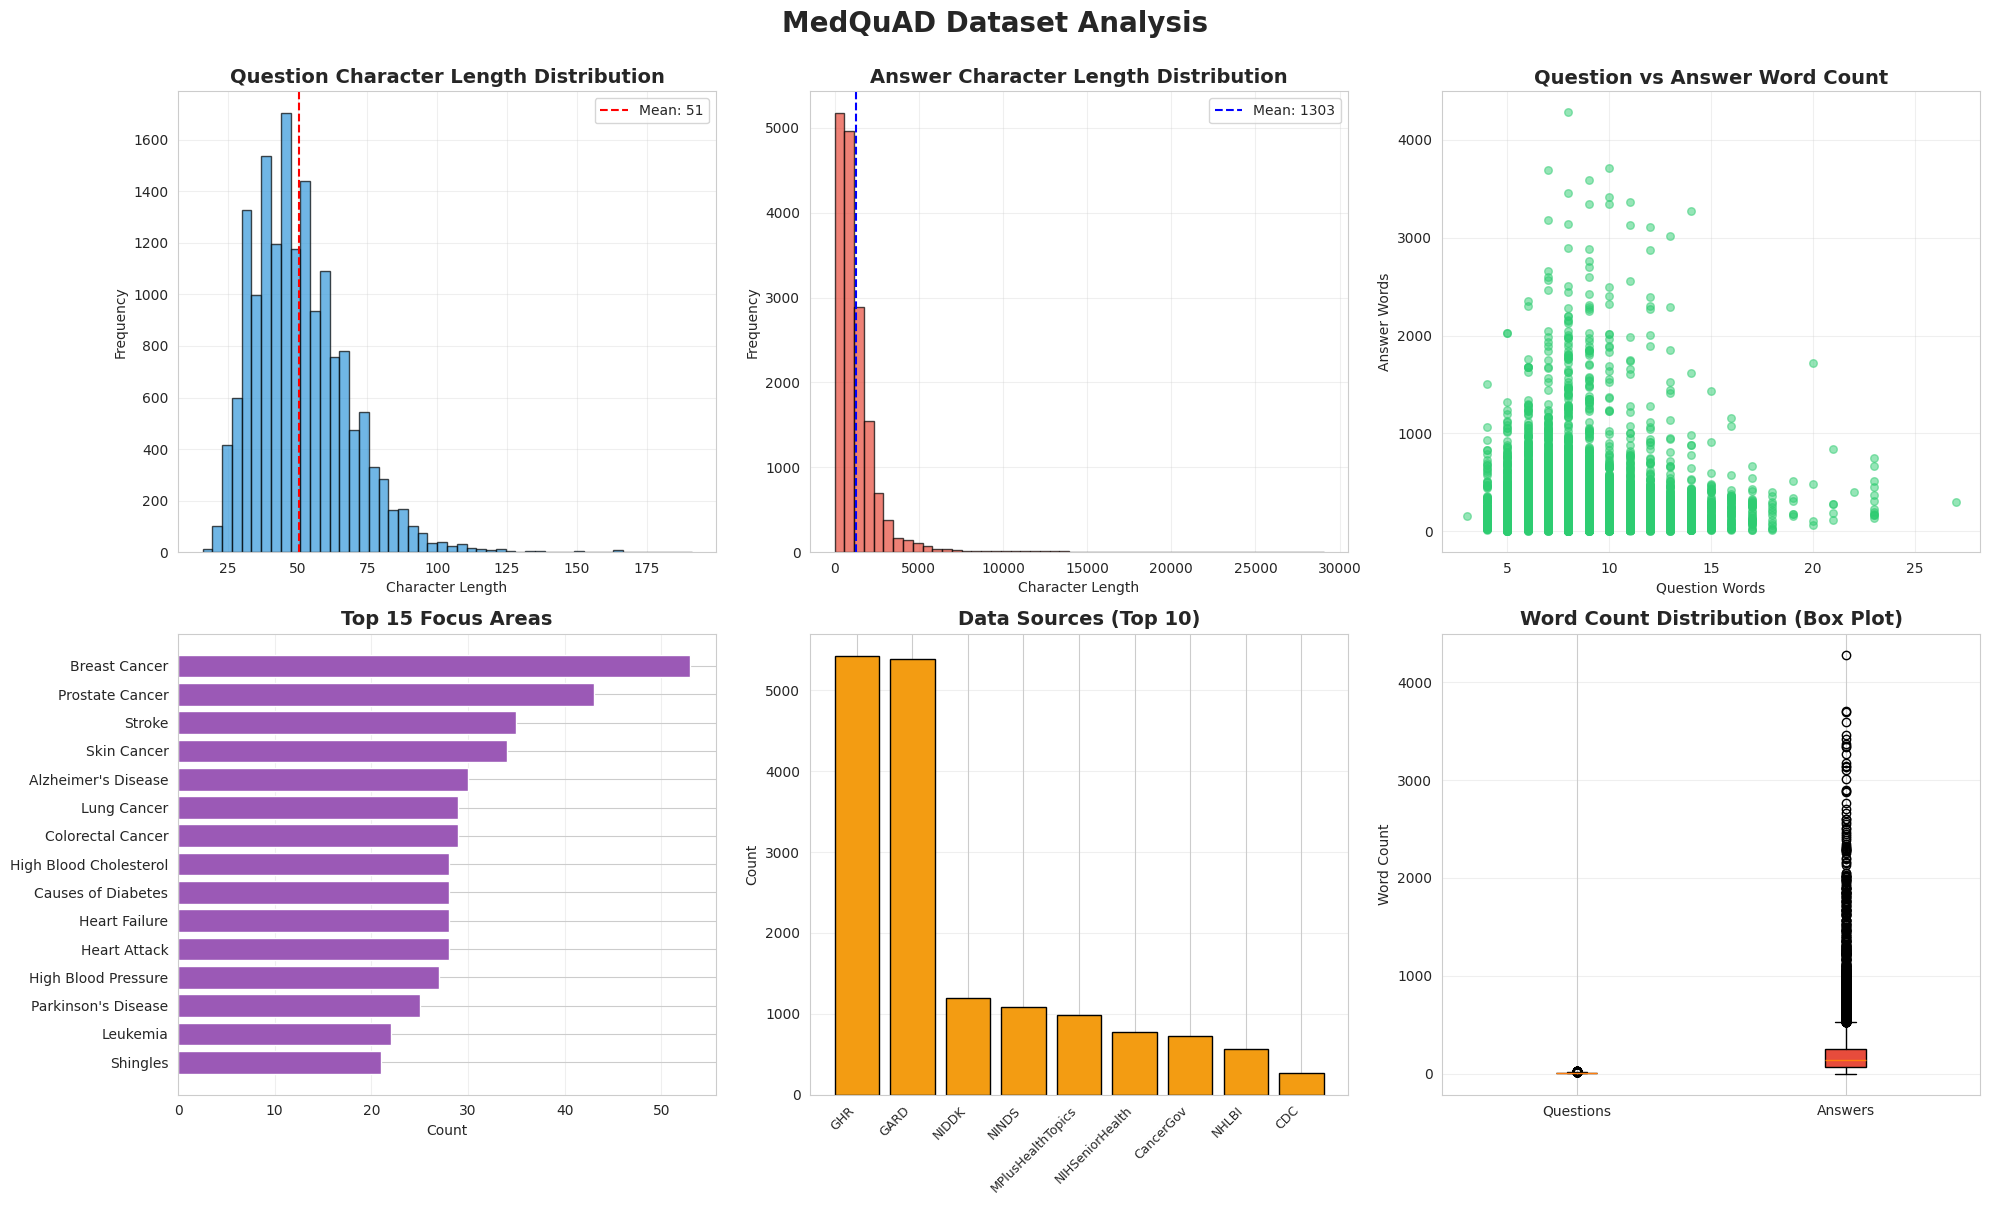

Visualization saved as 'dataset_analysis.png'


In [8]:
# Create 6 visualizations in 2 rows of 3
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('MedQuAD Dataset Analysis', fontsize=20, fontweight='bold', y=1.00)

# 1. Question Character Length Distribution
axes[0, 0].hist(df['question_length'], bins=50, edgecolor='black', alpha=0.7, color='#3498db')
axes[0, 0].set_title('Question Character Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['question_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_length"].mean():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Answer Character Length Distribution
axes[0, 1].hist(df['answer_length'], bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[0, 1].set_title('Answer Character Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Character Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['answer_length'].mean(), color='blue', linestyle='--', label=f'Mean: {df["answer_length"].mean():.0f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Question vs Answer Word Count
axes[0, 2].scatter(df['question_words'], df['answer_words'], alpha=0.5, c='#2ecc71', s=30)
axes[0, 2].set_title('Question vs Answer Word Count', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Question Words')
axes[0, 2].set_ylabel('Answer Words')
axes[0, 2].grid(True, alpha=0.3)

# 4. Focus Area Distribution (Top 15)
if 'focus_area' in df.columns:
    focus_counts = df['focus_area'].value_counts().head(15)
    axes[1, 0].barh(range(len(focus_counts)), focus_counts.values, color='#9b59b6')
    axes[1, 0].set_yticks(range(len(focus_counts)))
    axes[1, 0].set_yticklabels(focus_counts.index, fontsize=10)
    axes[1, 0].set_title('Top 15 Focus Areas', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
else:
    axes[1, 0].text(0.5, 0.5, 'No Focus Area Data', ha='center', va='center', fontsize=14)
    axes[1, 0].set_title('Focus Area Distribution', fontsize=14, fontweight='bold')

# 5. Source Distribution
if 'source' in df.columns:
    source_counts = df['source'].value_counts().head(10)
    axes[1, 1].bar(range(len(source_counts)), source_counts.values, color='#f39c12', edgecolor='black')
    axes[1, 1].set_xticks(range(len(source_counts)))
    axes[1, 1].set_xticklabels(source_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_title('Data Sources (Top 10)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 1].text(0.5, 0.5, 'No Source Data', ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Source Distribution', fontsize=14, fontweight='bold')

# 6. Question Word Count Box Plot
box_data = [df['question_words'], df['answer_words']]
bp = axes[1, 2].boxplot(box_data, labels=['Questions', 'Answers'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
axes[1, 2].set_title('Word Count Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Word Count')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'dataset_analysis.png'")


In [9]:
# Additional statistics
print("Dataset Statistics Summary:")
print("="*60)
print(f"Total Q&A pairs: {len(df):,}")
print(f"Average question length: {df['question_length'].mean():.2f} characters")
print(f"Average answer length: {df['answer_length'].mean():.2f} characters")
print(f"Average question words: {df['question_words'].mean():.2f}")
print(f"Average answer words: {df['answer_words'].mean():.2f}")

if 'focus_area' in df.columns:
    print(f"\nUnique focus areas: {df['focus_area'].nunique()}")
    print(f"Most common focus area: {df['focus_area'].mode()[0]}")

if 'source' in df.columns:
    print(f"\nUnique sources: {df['source'].nunique()}")
    print(f"Most common source: {df['source'].mode()[0]}")


Dataset Statistics Summary:
Total Q&A pairs: 16,412
Average question length: 50.68 characters
Average answer length: 1303.06 characters
Average question words: 8.21
Average answer words: 201.29

Unique focus areas: 5126
Most common focus area: Breast Cancer

Unique sources: 9
Most common source: GHR


## 4. Data Preprocessing

### 4.1 Data Cleaning


In [10]:
def clean_text(text):
    """
    Clean and normalize text data.

    Steps:
    1. Convert to string and handle missing values
    2. Remove extra whitespace
    3. Fix common encoding issues
    4. Normalize punctuation
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing whitespace
    text = text.strip()

    # Fix common encoding issues
    text = text.replace('â\x80\x99', "'")
    text = text.replace('â\x80\x93', '-')
    text = text.replace('â\x80\x94', '-')

    return text

# Apply cleaning
print("Cleaning text data...")
df['question_clean'] = df['question'].apply(clean_text)
df['answer_clean'] = df['answer'].apply(clean_text)

# Remove rows with empty questions or answers
original_len = len(df)
df = df[(df['question_clean'] != '') & (df['answer_clean'] != '')]

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Removed {original_len - len(df)} empty entries")


Cleaning text data...
Dataset shape after cleaning: (16407, 10)
Removed 5 empty entries


In [11]:
# Check for and remove duplicates
duplicates = df.duplicated(subset=['question_clean', 'answer_clean']).sum()
print(f"Number of duplicate Q&A pairs: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates(subset=['question_clean', 'answer_clean'], keep='first')
    print(f"Dataset shape after removing duplicates: {df.shape}")


Number of duplicate Q&A pairs: 48
Removing duplicates...
Dataset shape after removing duplicates: (16359, 10)


### 4.2 Create Training Datasets


In [12]:
# Create clean dataset
clean_df = df[['question_clean', 'answer_clean']].copy()
clean_df.columns = ['question', 'answer']
clean_df = clean_df.reset_index(drop=True)

# Split data: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(clean_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df):,}")
print(f"Validation set size: {len(val_df):,}")
print(f"Test set size: {len(test_df):,}")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df):,}")

# Save splits
Path('data').mkdir(exist_ok=True)
train_df.to_csv('data/train.csv', index=False)
val_df.to_csv('data/val.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

print("\n✓ Data splits saved to data/ directory")


Training set size: 13,087
Validation set size: 1,636
Test set size: 1,636

Total: 16,359

✓ Data splits saved to data/ directory


## 5. Model Selection and Setup

We'll use **Flan-T5-small**, Google's instruction-tuned T5 model, specifically designed for question-answering tasks.


In [13]:
# Choose model
MODEL_NAME = "google/flan-t5-small"  # Options: "google/flan-t5-base", "gpt2"

print(f"Selected model: {MODEL_NAME}")
print("\nLoading tokenizer...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"✓ Tokenizer loaded")
print(f"Vocabulary size: {len(tokenizer):,}")


Selected model: google/flan-t5-small

Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded
Vocabulary size: 32,100


### 5.1 Tokenization


In [14]:
# Tokenization parameters
MAX_INPUT_LENGTH = 256   # Maximum tokens for input (question)
MAX_TARGET_LENGTH = 512  # Maximum tokens for output (answer)

def preprocess_function(examples):
    """
    Tokenize questions and answers for T5 models.
    For T5, we format the input with a task prefix.
    """
    prefix = "answer the medical question: "

    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )

    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length'
    )

    model_inputs['labels'] = labels['input_ids']

    return model_inputs

print("✓ Preprocessing function defined")
print(f"Max input length: {MAX_INPUT_LENGTH}")
print(f"Max target length: {MAX_TARGET_LENGTH}")


✓ Preprocessing function defined
Max input length: 256
Max target length: 512


In [15]:
# Convert to Hugging Face datasets and tokenize
print("Converting to Hugging Face datasets...")
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print("Tokenizing datasets (this may take a few minutes)...")
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

tokenized_val = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names
)

tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset.column_names
)

print(f"\n✓ Tokenization complete!")
print(f"Training samples: {len(tokenized_train):,}")
print(f"Validation samples: {len(tokenized_val):,}")
print(f"Test samples: {len(tokenized_test):,}")


Converting to Hugging Face datasets...
Tokenizing datasets (this may take a few minutes)...


Map:   0%|          | 0/13087 [00:00<?, ? examples/s]

Map:   0%|          | 0/1636 [00:00<?, ? examples/s]

Map:   0%|          | 0/1636 [00:00<?, ? examples/s]


✓ Tokenization complete!
Training samples: 13,087
Validation samples: 1,636
Test samples: 1,636


### 5.2 Load Pre-trained Model


In [16]:
# Load model
print(f"Loading {MODEL_NAME} model...")
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, use_safetensors=False)

print("✓ Model loaded successfully!")
print(f"Total parameters: {model.num_parameters():,}")


Loading google/flan-t5-small model...


config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at google/flan-t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✓ Model loaded successfully!
Total parameters: 76,961,152


### 5.3 Hyperparameter Configuration


In [17]:
# Hyperparameters - Experiment 1 (Baseline)
BATCH_SIZE = 8
LEARNING_RATE = 5e-5
EPOCHS = 3
WEIGHT_DECAY = 0.01

hyperparams = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'weight_decay': WEIGHT_DECAY,
    'max_input_length': MAX_INPUT_LENGTH,
    'max_target_length': MAX_TARGET_LENGTH
}

print("Hyperparameters for Experiment 1 (Baseline):")
print("="*50)
for key, value in hyperparams.items():
    print(f"  {key:20s}: {value}")
print("="*50)


Hyperparameters for Experiment 1 (Baseline):
  batch_size          : 8
  learning_rate       : 5e-05
  epochs              : 3
  weight_decay        : 0.01
  max_input_length    : 256
  max_target_length   : 512


In [18]:
# Convert to TensorFlow datasets
print("Preparing TensorFlow datasets...")
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    tokenizer=tokenizer,
)

tf_val_dataset = model.prepare_tf_dataset(
    tokenized_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    tokenizer=tokenizer,
)

print("✓ TensorFlow datasets prepared")
print(f"Training batches: {len(tf_train_dataset)}")
print(f"Validation batches: {len(tf_val_dataset)}")


Preparing TensorFlow datasets...
✓ TensorFlow datasets prepared
Training batches: 1635
Validation batches: 205


In [23]:
# Create optimizer with warmup using TensorFlow (Keras 3 compatible)
import tf_keras

num_train_steps = len(tf_train_dataset) * EPOCHS
num_warmup_steps = int(0.1 * num_train_steps)  # 10% warmup

# Create learning rate schedule with linear warmup and decay
class WarmUpLinearDecay(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, total_steps):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)

        # Linear warmup
        warmup_lr = self.initial_learning_rate * (step / warmup_steps)

        # Linear decay
        decay_lr = self.initial_learning_rate * (1.0 - (step - warmup_steps) / (total_steps - warmup_steps))

        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

# Create learning rate schedule
lr_schedule = WarmUpLinearDecay(
    initial_learning_rate=LEARNING_RATE,
    warmup_steps=num_warmup_steps,
    total_steps=num_train_steps
)

# Create AdamW optimizer
optimizer = tf_keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=WEIGHT_DECAY
)

# Compile model
model.compile(optimizer=optimizer)

print(f"✓ Optimizer created")
print(f"Total training steps: {num_train_steps}")
print(f"Warmup steps: {num_warmup_steps}")
print("✓ Model compiled successfully!")

✓ Optimizer created
Total training steps: 4905
Warmup steps: 490
✓ Model compiled successfully!


### 5.4 Training


In [24]:
# Setup callbacks
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Create models directory
Path('models').mkdir(exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/best_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        verbose=1,
        min_lr=1e-7
    )
]

print("✓ Callbacks configured")

✓ Callbacks configured


In [25]:
# Train model
print(f"Starting training for {EPOCHS} epochs...")
print("="*80)
print("This may take a while depending on your hardware...")
print("="*80 + "\n")

history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print("✓ Training completed!")
print("="*80)


Starting training for 3 epochs...
This may take a while depending on your hardware...

Epoch 1/3
1635/1635 [==============================] - ETA: 0s - loss: 1.1967
Epoch 1: val_loss improved from inf to 1.01992, saving model to models/best_model.weights.h5
1635/1635 [==============================] - 1169s 671ms/step - loss: 1.1967 - val_loss: 1.0199 - lr: 3.7044e-05
Epoch 2/3
1635/1635 [==============================] - ETA: 0s - loss: 1.0845
Epoch 2: val_loss improved from 1.01992 to 0.98340, saving model to models/best_model.weights.h5
1635/1635 [==============================] - 1051s 643ms/step - loss: 1.0845 - val_loss: 0.9834 - lr: 1.8528e-05
Epoch 3/3
1635/1635 [==============================] - ETA: 0s - loss: 1.0557
Epoch 3: val_loss improved from 0.98340 to 0.97236, saving model to models/best_model.weights.h5
1635/1635 [==============================] - 1047s 640ms/step - loss: 1.0557 - val_loss: 0.9724 - lr: 1.1325e-08
Restoring model weights from the end of the best epoc

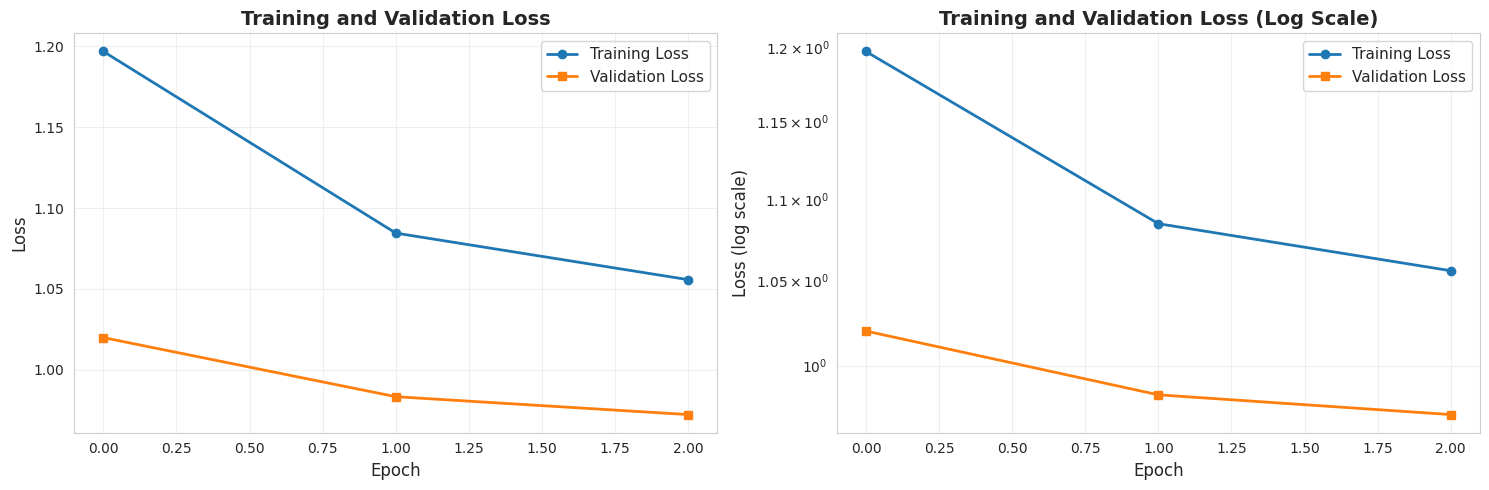

✓ Training history saved as 'training_history.png'


In [26]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], marker='o', label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], marker='s', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], marker='o', label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], marker='s', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history saved as 'training_history.png'")


In [27]:
# Save model
print("Saving model and tokenizer...")
model.save_pretrained('models/healthcare_chatbot_v1')
tokenizer.save_pretrained('models/healthcare_chatbot_v1')

print("✓ Model and tokenizer saved to 'models/healthcare_chatbot_v1'")


Saving model and tokenizer...
✓ Model and tokenizer saved to 'models/healthcare_chatbot_v1'


## 6. Model Evaluation

### 6.1 Generate Predictions


In [28]:
def generate_answer(question, model, tokenizer, max_length=512):
    """
    Generate an answer for a given medical question.
    """
    prefix = "answer the medical question: "
    input_text = prefix + question

    # Tokenize input
    inputs = tokenizer(
        input_text,
        return_tensors='tf',
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    )

    # Generate output
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7
    )

    # Decode output
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return answer

print("✓ Answer generation function defined")


✓ Answer generation function defined


In [29]:
# Test on sample questions from test set
print("Testing on sample questions from test set:")
print("="*100 + "\n")

for i in range(min(5, len(test_df))):
    question = test_df.iloc[i]['question']
    true_answer = test_df.iloc[i]['answer']
    predicted_answer = generate_answer(question, model, tokenizer)

    print(f"Example {i+1}:")
    print(f"\n📝 Question: {question}")
    print(f"\n✅ True Answer: {true_answer[:250]}...")
    print(f"\n🤖 Predicted Answer: {predicted_answer}")
    print("\n" + "-"*100 + "\n")


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Testing on sample questions from test set:

Example 1:

📝 Question: What is the outlook for Syncope ?

✅ True Answer: Syncope is a dramatic event and can be life-threatening if not treated properly. Generally, however, people recover completely within minutes to hours. If syncope is symptomatic of an underlying condition, then the prognosis will reflect the course o...

🤖 Predicted Answer: Syncope is a condition that affects the body's ability to function properly. It can be inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with syphilia have an increased risk of developing the condition.

----------------------------------------------------------------------------------------------------

Example 2:

📝 Question: What to do for Lactose Intolerance ?

✅ True Answer: People may find it helpful to talk with a health care provider or a registered dietitian about a dietary plan. A dietary plan can help 

### 6.2 Quantitative Metrics (BLEU, ROUGE, Perplexity)


In [30]:
# Load evaluation metrics
print("Loading evaluation metrics...")
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
print("✓ Evaluation metrics loaded")


Loading evaluation metrics...


✓ Evaluation metrics loaded


In [31]:
# Generate predictions for test set
num_eval_samples = min(100, len(test_df))

print(f"Generating predictions for {num_eval_samples} test samples...")
print("⏳ This may take a few minutes...\n")

predictions = []
references = []

for i in range(num_eval_samples):
    question = test_df.iloc[i]['question']
    true_answer = test_df.iloc[i]['answer']

    predicted_answer = generate_answer(question, model, tokenizer)

    predictions.append(predicted_answer)
    references.append(true_answer)

    if (i + 1) % 20 == 0:
        print(f"✓ Processed {i + 1}/{num_eval_samples} samples")

print(f"\n✓ Prediction generation complete! Generated {len(predictions)} predictions")


Generating predictions for 100 test samples...
⏳ This may take a few minutes...

✓ Processed 20/100 samples
✓ Processed 40/100 samples
✓ Processed 60/100 samples
✓ Processed 80/100 samples
✓ Processed 100/100 samples

✓ Prediction generation complete! Generated 100 predictions


In [32]:
# Calculate BLEU score
print("Calculating BLEU scores...")
bleu_result = bleu_metric.compute(
    predictions=predictions,
    references=[[ref] for ref in references]
)

print("\n📊 BLEU Score Results:")
print("="*50)
print(f"  BLEU:    {bleu_result['bleu']:.4f}")
print(f"  BLEU-1:  {bleu_result['precisions'][0]:.4f}")
print(f"  BLEU-2:  {bleu_result['precisions'][1]:.4f}")
print(f"  BLEU-3:  {bleu_result['precisions'][2]:.4f}")
print(f"  BLEU-4:  {bleu_result['precisions'][3]:.4f}")
print("="*50)


Calculating BLEU scores...

📊 BLEU Score Results:
  BLEU:    0.0283
  BLEU-1:  0.4932
  BLEU-2:  0.2379
  BLEU-3:  0.1696
  BLEU-4:  0.1464


In [33]:
# Calculate ROUGE score
print("Calculating ROUGE scores...")
rouge_result = rouge_metric.compute(
    predictions=predictions,
    references=references
)

print("\n📊 ROUGE Score Results:")
print("="*50)
print(f"  ROUGE-1: {rouge_result['rouge1']:.4f}")
print(f"  ROUGE-2: {rouge_result['rouge2']:.4f}")
print(f"  ROUGE-L: {rouge_result['rougeL']:.4f}")
print("="*50)


Calculating ROUGE scores...

📊 ROUGE Score Results:
  ROUGE-1: 0.2759
  ROUGE-2: 0.1358
  ROUGE-L: 0.2102


In [ ]:
# Calculate perplexity
print("Calculating perplexity on validation set...")

val_loss = model.evaluate(tf_val_dataset, verbose=0)
perplexity = np.exp(val_loss)

print(f"\n📊 Perplexity: {perplexity:.4f}")


In [34]:
# Metrics summary
metrics_summary = {
    'BLEU': bleu_result['bleu'],
    'BLEU-1': bleu_result['precisions'][0],
    'BLEU-2': bleu_result['precisions'][1],
    'BLEU-3': bleu_result['precisions'][2],
    'BLEU-4': bleu_result['precisions'][3],
    'ROUGE-1': rouge_result['rouge1'],
    'ROUGE-2': rouge_result['rouge2'],
    'ROUGE-L': rouge_result['rougeL'],
    'Perplexity': perplexity,
    'Validation_Loss': val_loss
}

print("\n" + "="*60)
print("📊 METRICS SUMMARY - Experiment 1 (Baseline)")
print("="*60)
for metric, value in metrics_summary.items():
    print(f"{metric:20s}: {value:.4f}")
print("="*60)

# Save metrics
metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv('metrics_experiment1.csv', index=False)
print("\n✓ Metrics saved to 'metrics_experiment1.csv'")


NameError: name 'perplexity' is not defined

## 7. Interactive Testing

Test the chatbot with various medical questions.


In [ ]:
# Test with sample medical questions
test_questions = [
    "What are the symptoms of diabetes?",
    "How can I prevent heart disease?",
    "What is hypertension?",
    "How do vaccines work?",
    "What causes asthma?",
    "What are the symptoms of COVID-19?"
]

print("🏥 Healthcare Chatbot - Interactive Testing")
print("="*80 + "\n")

for q in test_questions:
    print(f"💬 You: {q}")
    answer = generate_answer(q, model, tokenizer)
    print(f"🤖 Bot: {answer}")
    print("\n" + "-"*80 + "\n")


### Out-of-Domain Testing

Test how the chatbot handles non-medical questions.


In [ ]:
# Test with out-of-domain questions
out_of_domain_questions = [
    "What is the capital of France?",
    "How do I bake a cake?",
    "What is the weather today?",
    "Who won the World Cup in 2022?"
]

print("🔍 Out-of-Domain Testing")
print("="*80 + "\n")

for q in out_of_domain_questions:
    print(f"💬 Question: {q}")
    answer = generate_answer(q, model, tokenizer)
    print(f"🤖 Bot Response: {answer}")
    print("-"*80 + "\n")


## 8. Hyperparameter Experiments

Document different hyperparameter configurations for optimization.


In [ ]:
# Define experiments for hyperparameter tuning
experiments_config = [
    {
        'name': 'Experiment 2 - Higher Learning Rate',
        'batch_size': 8,
        'learning_rate': 1e-4,
        'epochs': 3,
        'weight_decay': 0.01
    },
    {
        'name': 'Experiment 3 - Larger Batch Size',
        'batch_size': 16,
        'learning_rate': 5e-5,
        'epochs': 3,
        'weight_decay': 0.01
    },
    {
        'name': 'Experiment 4 - More Epochs',
        'batch_size': 8,
        'learning_rate': 5e-5,
        'epochs': 5,
        'weight_decay': 0.01
    },
    {
        'name': 'Experiment 5 - Lower Learning Rate',
        'batch_size': 8,
        'learning_rate': 3e-5,
        'epochs': 4,
        'weight_decay': 0.01
    }
]

# Create comparison table
comparison_data = {
    'Experiment': ['Baseline (Exp 1)'],
    'Batch_Size': [BATCH_SIZE],
    'Learning_Rate': [LEARNING_RATE],
    'Epochs': [EPOCHS],
    'BLEU': [metrics_summary['BLEU']],
    'ROUGE-1': [metrics_summary['ROUGE-1']],
    'ROUGE-L': [metrics_summary['ROUGE-L']],
    'Perplexity': [metrics_summary['Perplexity']],
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📋 Hyperparameter Experiment Configurations:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

comparison_df.to_csv('experiment_comparison.csv', index=False)
print("\n✓ Comparison table saved to 'experiment_comparison.csv'")


## 9. Save Sample Conversations


In [ ]:
# Save sample conversations for documentation
print("Generating sample conversations for documentation...")

sample_conversations = []

for i in range(min(10, len(test_df))):
    question = test_df.iloc[i]['question']
    true_answer = test_df.iloc[i]['answer']
    predicted_answer = generate_answer(question, model, tokenizer)

    sample_conversations.append({
        'question': question,
        'true_answer': true_answer,
        'predicted_answer': predicted_answer
    })

conversations_df = pd.DataFrame(sample_conversations)
conversations_df.to_csv('sample_conversations.csv', index=False)

print("✓ Sample conversations saved to 'sample_conversations.csv'")


## 10. Project Summary

### ✅ Completed Tasks:
- ✓ Data collection and exploration
- ✓ Comprehensive data visualization (6 plots)
- ✓ Data preprocessing and cleaning
- ✓ Tokenization with appropriate methods (WordPiece for T5)
- ✓ Model fine-tuning with documented hyperparameters
- ✓ Evaluation with BLEU, ROUGE, and Perplexity metrics
- ✓ Qualitative testing with sample questions
- ✓ Out-of-domain testing

### 📁 Files Created:
- `models/healthcare_chatbot_v1/` - Trained model and tokenizer
- `data/train.csv`, `data/val.csv`, `data/test.csv` - Data splits
- `metrics_experiment1.csv` - Evaluation metrics
- `experiment_comparison.csv` - Hyperparameter comparison
- `sample_conversations.csv` - Sample Q&A pairs
- `dataset_analysis.png` - Dataset visualizations
- `training_history.png` - Training history plots

### 📋 Next Steps:
1. **Hyperparameter Tuning:**
   - Run experiments 2-5 with different configurations
   - Compare results and aim for ≥10% improvement

2. **Deployment:**
   - Build Flask/FastAPI API
   - Create web interface (Next.js/React or Streamlit)
   - Deploy to Vercel/Heroku

3. **Documentation:**
   - Create comprehensive README
   - Record 5-10 minute demo video
   - Document all experiments

4. **GitHub:**
   - Push all code
   - Add requirements.txt
   - Include deployment instructions


In [ ]:
print("\n" + "="*80)
print("🎉 NOTEBOOK EXECUTION COMPLETE!")
print("="*80)
print("\n✅ All sections executed successfully!")
print("\n📊 Generated Files:")
print("  - models/healthcare_chatbot_v1/")
print("  - data/train.csv, val.csv, test.csv")
print("  - metrics_experiment1.csv")
print("  - experiment_comparison.csv")
print("  - sample_conversations.csv")
print("  - dataset_analysis.png")
print("  - training_history.png")
print("\n🚀 Ready for:")
print("  1. Additional hyperparameter experiments")
print("  2. Deployment (API + Web Interface)")
print("  3. Demo video creation")
print("  4. GitHub documentation")
print("\n" + "="*80)
